In [22]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter


# 1.1 Simulation


In [6]:
def pendulum_rhs(y, t, alpha, mu):
    z, dz = y
    return [dz, -mu * np.sin(z) - alpha * np.abs(dz)*dz]

In [7]:
def simulate_pendulum(num, dt, z0, dz0, alpha, mu):
    t = np.linspace(0, num*dt, num)
    return odeint(pendulum_rhs, [z0, dz0], t, args=(alpha, mu)), np.array([t])
    

In [8]:
def generate_phase_portrait_grid(num, dt, alpha, mu, n):
    z = np.linspace(-1, 1, n)
    dz = np.linspace(-1, 1, n)
    fig, axs = plt.subplots(n, n)
    plt.suptitle(fr"Phase portait with parameters: t: {num*dt}s, ic $\in [-1, 1]^2$ $\alpha$: {alpha}, $\mu$: {mu}")
    for i in range(n):
        for j in range(n):
            z0 = z[i]
            dz0 = dz[j]
            z, dz = simulate_pendulum(num, dt, z0, dz0, alpha, mu)[0].T
            axs[i,j].plot(z, dz)
    fig.text(0.5, 0.01, 'z', ha='center')
    fig.text(0.01, 0.5, 'dz', va='center', rotation='vertical')
    
    plt.tight_layout()


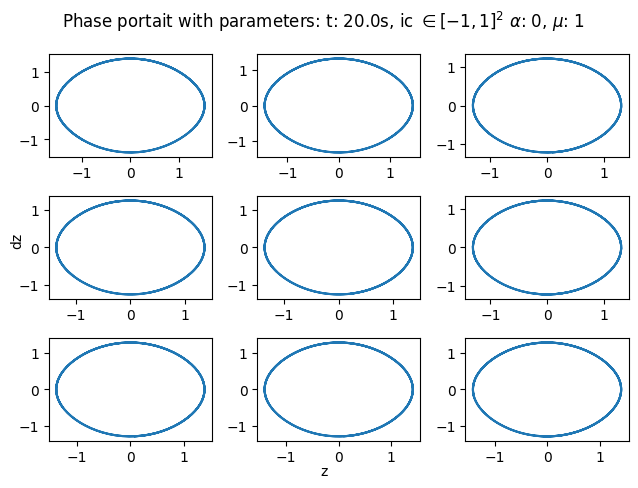

In [9]:
generate_phase_portrait_grid(200, 0.1,0, 1, 3)

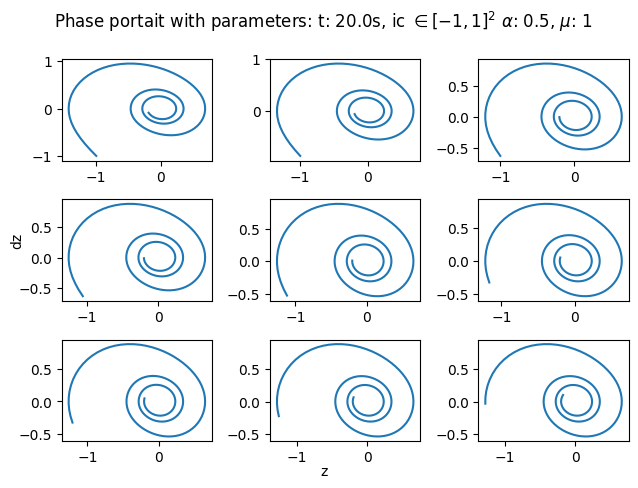

In [10]:
generate_phase_portrait_grid(200, 0.1, 0.5, 1, 3)

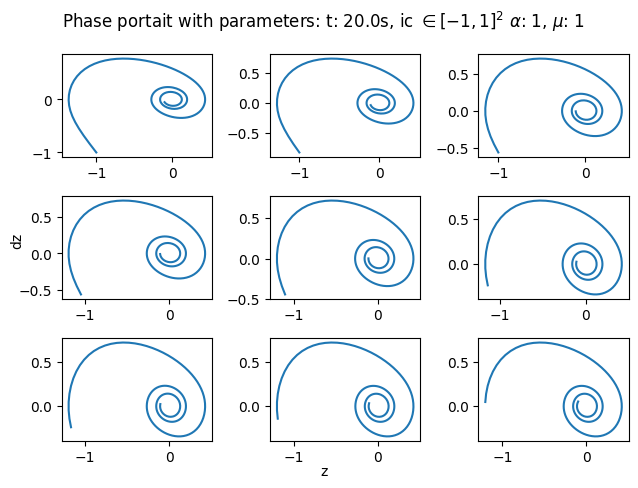

In [11]:
generate_phase_portrait_grid(200, 0.1, 1, 1, 3)

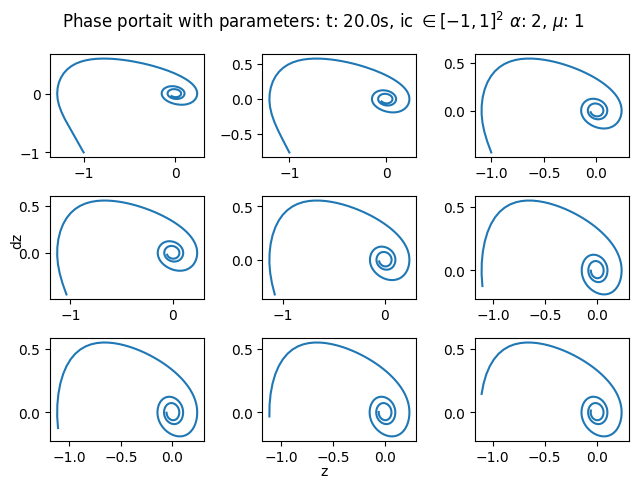

In [12]:
generate_phase_portrait_grid(200, 0.1, 2, 1, 3)

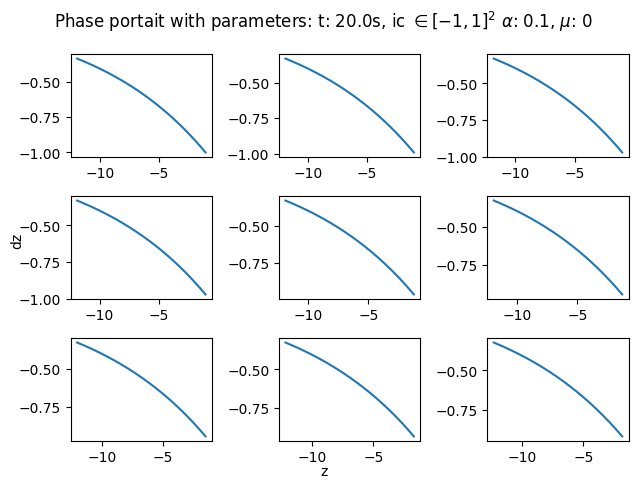

In [13]:
generate_phase_portrait_grid(200, 0.1, 0.1, 0, 3)

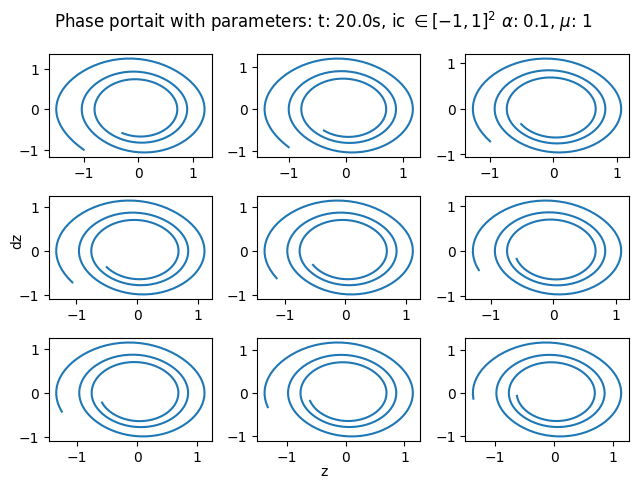

In [14]:
generate_phase_portrait_grid(200, 0.1, 0.1, 1, 3)

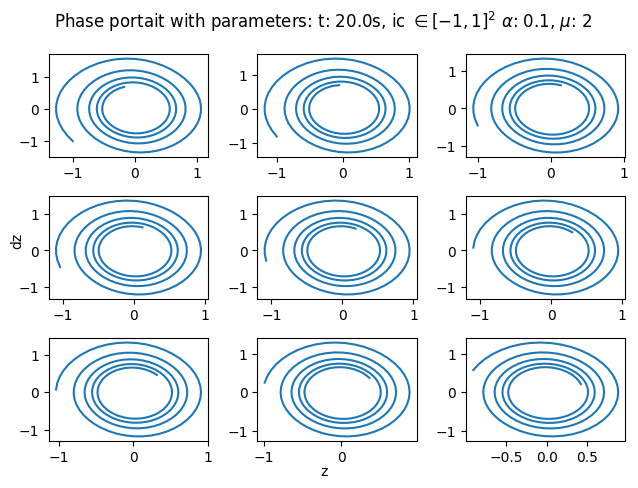

In [15]:
generate_phase_portrait_grid(200, 0.1, 0.1, 2, 3)

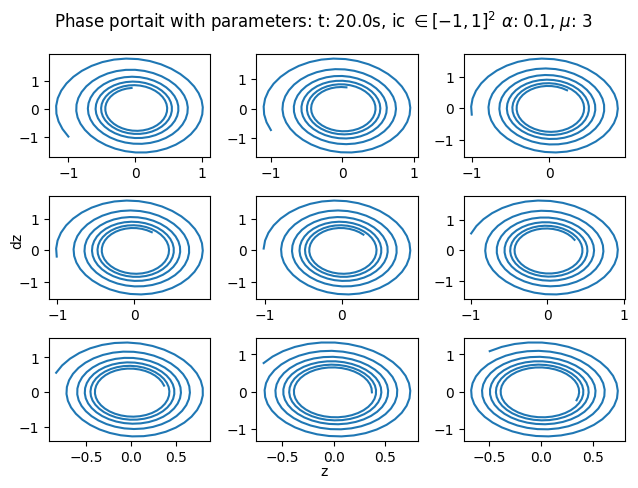

In [16]:
generate_phase_portrait_grid(200, 0.1, 0.1, 3, 3)

# 1.2

In [99]:
class PINN(nn.Module):
    def __init__(self, input_size, output_size, number_of_layers, layer_size, activation_function, rhs):
        super().__init__()
        self.layers = [nn.Linear(input_size, layer_size)]
        
        for n in range(number_of_layers):
            self.layers.append(nn.Linear(layer_size, layer_size))
            self.layers.append(activation_function())
        
        self.layers.append(nn.Linear(layer_size, output_size))
        
        self.layers = nn.Sequential(*self.layers)
        self.rhs = rhs
        self.criterion = nn.MSELoss()
        
        self.lambda_ode = 1
        self.lambda_data = 0.5
    
    def forward(self, T):
        T = T.reshape(-1, 1)
        return torch.sin(self.layers(T))
    
    def loss_ODE(self, T):
        x = self.forward(T)
        dx = self.rhs(x, _).T
        return self.criterion(x, dx)
    
    def loss_data(self, X, T):
        return self.criterion(self.forward(T), X)
    
    def total_loss(self, T, CPs):
        X_colocation = CPs[:, 1:] 
        T_colocation = CPs[:, 0] 
        return self.lambda_ode * self.loss_ODE(T)  #+ self.lambda_data * self.loss_data(X_colocation, T_colocation)
    
        
        
    
            
        
        
    

In [139]:
def train_pinn(model, t, train_data, num_cps, num_epochs, time_splits, lr=0.001):
    writer = SummaryWriter()
    data = np.hstack((t.T, train_data))
    X = torch.FloatTensor(data)
    dataset = TensorDataset(X)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_list=[]
    for epoch in range(num_epochs):
        for data in data_loader:
            input_times = data[0][:, 0]
            input_data = data[0][:, 1:]
            CPs = data[0][torch.randint(len(data[0]), (num_cps,))] 
            total_loss = 0
            weights = [np.exp(-i) for i in range(time_splits)]
            for i in range(1, time_splits+1):
                delta_t = int(len(input_times) / time_splits)
                delta_c = int(len(CPs) / time_splits)
                loss = model.total_loss(input_times[(i-1)*delta_t:i*delta_t], CPs[(i-1)*delta_c:i*delta_c])
                total_loss += weights[i-1] * loss
                if epoch % 100 == 0 and epoch != 0:
                    print(weights[i-1])
                    weights[i-1] = torch.log(-total_loss + weights[i-1] * loss)
                    print(weights[i-1])
                    writer.add_scalar("Weights", weights[i-1], epoch)

                
                

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        #writer.add_scalar('Weights', total_loss, epoch)
        loss_list.append(total_loss.item())

    return loss_list
    
   

In [131]:
alpha = 0
mu = 1
data_train, t = simulate_pendulum(200, 0.1, 0, 0.9, alpha, mu)

In [132]:
model = PINN(1, 2, 2, 128, nn.GELU, lambda y, t: torch.FloatTensor(pendulum_rhs(y.detach().numpy().T, t, alpha, mu)))

In [133]:
loss_list = train_pinn(model, t, data_train,500, 150, 2)

tensor(-inf, grad_fn=<LogBackward0>)
tensor(nan, grad_fn=<LogBackward0>)
tensor(-inf, grad_fn=<LogBackward0>)
tensor(nan, grad_fn=<LogBackward0>)
tensor(-inf, grad_fn=<LogBackward0>)
tensor(nan, grad_fn=<LogBackward0>)
tensor(-inf, grad_fn=<LogBackward0>)
tensor(nan, grad_fn=<LogBackward0>)


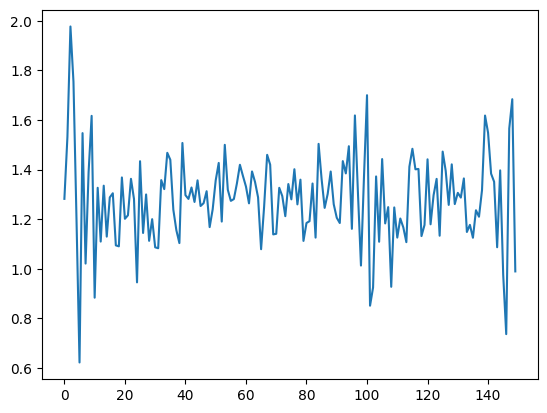

In [134]:
plt.plot(loss_list)

In [135]:
T = torch.FloatTensor(t)
X = model.forward(T)
X = X.detach().numpy()

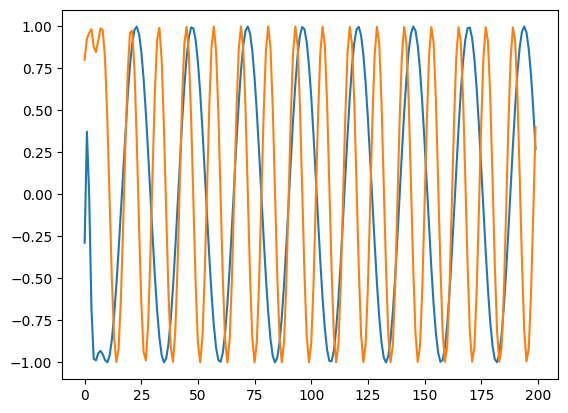

In [136]:
plt.plot(X)

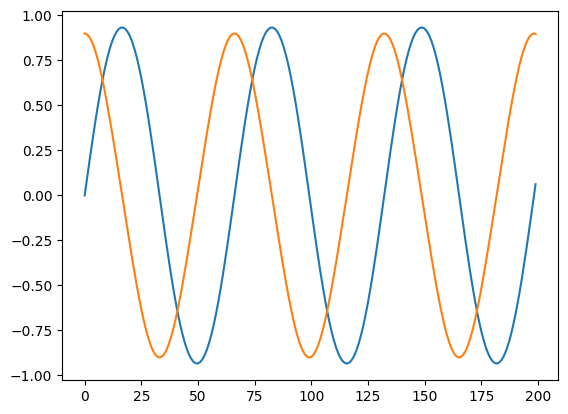

In [117]:
plt.plot(data_train)